# Part 1 — Rock Performers Network Analysis (LWCC)

**Goal:** Present a concise, self-contained analysis of the network of bands/artists built from Wikipedia links (largest weakly connected component, LWCC). Use tools from **Lecture 5** (week5.py) and basic network measures (e.g., degree distribution from week4) to characterize the network for an audience that knows network science but not this specific network.

**Focus topics (not exhaustive):**
- Network summary and degree distribution (baseline).
- Centrality (degree + one advanced centrality).
- Degree/attribute assortativity.
- A **network backbone** (k-core) to focus on the dense core.
- At least one **network visualization** (ForceAtlas2 on the backbone).

We deliberately **avoid an exhaustive dump**. Instead we select a few informative measures/plots and explain what they say about this network.


### Overview of our analytical approach

We approached this analysis by first identifying the most meaningful ways to describe the structure of the rock performers network without overwhelming the reader with redundant metrics. We decided to begin with fundamental properties such as the degree distribution to establish the network’s overall connectivity pattern. Building on this baseline, we examined centrality measures—degree and betweenness—to highlight key artists that act as either hubs or bridges. We then explored assortativity to understand whether highly connected or content-rich nodes tend to link with similar ones, providing insights into homophily and hierarchical tendencies in the network. Finally, to visualize and summarize the dense structural core, we extracted a network backbone using k-core decomposition and plotted it using a ForceAtlas2 layout. Throughout, we balanced completeness with interpretability, focusing on measures that best convey the character and organization of the rock performer network.


In [1]:
# Imports & reproducibility
import math
import pickle
import warnings
from collections import Counter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Reproducibility: control randomness in layouts and sampling
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot settings
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

# Make warnings less noisy in notebook output
warnings.filterwarnings("ignore", category=UserWarning)

def safe_forceatlas2_layout(G, seed=RANDOM_SEED, **kwargs):
    """
    Try to use NetworkX's ForceAtlas2 layout (NX >= 3.5).
    If not available, fall back to spring_layout with a fixed seed.
    """
    if hasattr(nx, "forceatlas2_layout"):
        return nx.forceatlas2_layout(G, seed=seed, **kwargs)
    # Fallback (still deterministic via seed)
    return nx.spring_layout(G, seed=seed, k=None, iterations=300)

def alias_content_length_attributes(G):
    """
    Some course notebooks used 'content_length' while others used 'length_of_content'.
    Create a consistent 'length_of_content' attribute for all nodes.
    """
    for n, data in G.nodes(data=True):
        if "length_of_content" not in data:
            data["length_of_content"] = data.get("content_length", 0)



## Data — Load the LWCC graph

We load the **largest weakly connected component** of the Wikipedia rock performers graph (`rock_performers_LWCC.gpickle`). If the file is not present locally, we download it from the provided GitHub RAW URL.


In [ ]:
import os, requests

RAW_GPICKLE_URL = (
    "https://raw.githubusercontent.com/LeoItaly/02805-social-graphs-interactions/main/Assignment%201/rock_performers_LWCC.gpickle"
)

local_path = "rock_performers_LWCC.gpickle"

if not os.path.exists(local_path):
    print("Downloading LWCC gpickle from GitHub ...")
    resp = requests.get(RAW_GPICKLE_URL, timeout=30)
    resp.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(resp.content)
    print("Saved:", local_path)

# Load with pickle for maximum compatibility
with open(local_path, "rb") as f:
    H = pickle.load(f)

print(
    f"Loaded H (directed): {H.number_of_nodes()} nodes, "
    f"{H.number_of_edges()} edges, directed={H.is_directed()}"
)

Saved: rock_performers_LWCC.gpickle
Loaded H (directed): 483 nodes, 7587 edges, directed=True



## Undirected GCC used for structure

For degree distribution, assortativity, and the visualization we work on the **undirected** giant connected component.


In [ ]:
# Undirected GCC
G_und = H.to_undirected()
gcc_nodes = max(nx.connected_components(G_und), key=len)
G = G_und.subgraph(gcc_nodes).copy()

alias_content_length_attributes(G)

print(f"Undirected GCC: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Undirected GCC: 483 nodes, 6299 edges


## Degree distribution (baseline)

A basic fingerprint of the network. We summarize the (undirected) degree distribution and plot counts in log-log axes.

Average degree: 26.08
Median degree : 20
Max degree    : 356


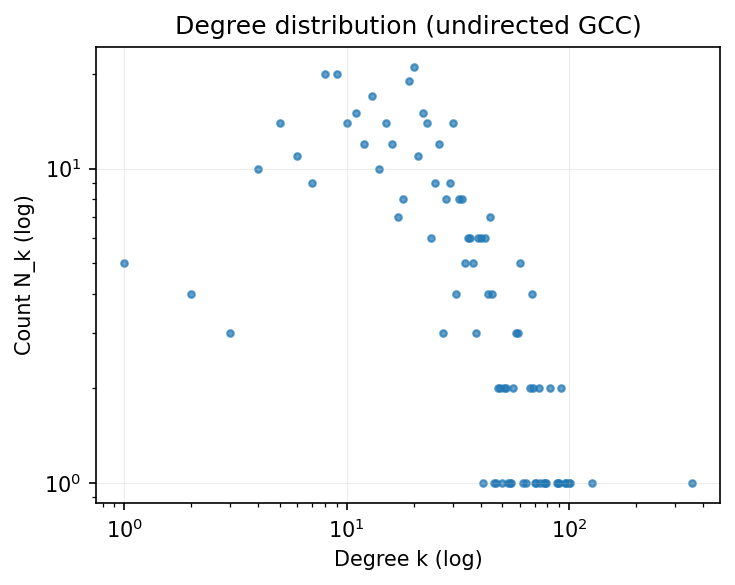

In [ ]:
deg = dict(G.degree())
deg_vals = np.array(list(deg.values()))

# Summary stats
print(f"Average degree: {deg_vals.mean():.2f}")
print(f"Median degree : {np.median(deg_vals):.0f}")
print(f"Max degree    : {deg_vals.max():.0f}")

# Degree histogram on log-log
deg_count = Counter(deg_vals)
xs = np.array(sorted(deg_count.keys()))
ys = np.array([deg_count[x] for x in xs])

fig, ax = plt.subplots(figsize=(5.0, 4.0))
ax.scatter(xs, ys, s=10, alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree k (log)")
ax.set_ylabel("Count N_k (log)")
ax.set_title("Degree distribution (undirected GCC)")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

The degree distribution of the rock performers network is clearly **right-skewed and heavy-tailed**.  
Most artists have relatively few connections—around 20 links on average (median degree = 20)—while a small minority of highly connected artists form hubs (maximum degree = 356).  
The approximate mean degree of 26.1 confirms that although the network is fairly well connected overall, connectivity is extremely uneven.  
This long-tail pattern suggests **preferential attachment–like dynamics**, where popular or historically influential artists accumulate disproportionately many links.  
Such structural heterogeneity provides motivation to explore **centrality measures** (to identify those key hubs and bridges) and **assortativity** (to see whether these high-degree nodes tend to connect with one another or with less connected artists).

## Centrality

We report nodes with high **degree centrality** (connectivity) and **betweenness centrality** (control of shortest paths). Betweenness is approximated for large graphs by sampling sources when needed.

In [5]:
# Degree centrality on the directed H (total in+out normalized by N-1)
deg_cent = nx.degree_centrality(H)

def topk_items(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top-10 by degree centrality (directed total):")
for n, v in topk_items(deg_cent, 10):
    print(f"{v:.4f}  {n}")

Top-10 by degree centrality (directed total):
0.7407  AllMusic
0.3071  Led_Zeppelin
0.2780  Black_Sabbath
0.2759  Queen_(band)
0.2739  Metallica
0.2614  Bob_Dylan
0.2593  Alice_in_Chains
0.2531  Deep_Purple
0.2365  Guns_N'_Roses
0.2261  Jimi_Hendrix


In [6]:
# Betweenness centrality (approximate if N large)
N = H.number_of_nodes()
if N <= 3000:
    btw = nx.betweenness_centrality(H, normalized=True)
else:
    # Sample sources for speed; reproducible via seed
    k = min(300, N)
    rng = np.random.default_rng(RANDOM_SEED)
    sources = rng.choice(list(H.nodes()), size=k, replace=False)
    btw = nx.betweenness_centrality(H, k=k, normalized=True, seed=RANDOM_SEED)

print("\nTop-10 by betweenness centrality (directed):")
for n, v in topk_items(btw, 10):
    print(f"{v:.5f}  {n}")


Top-10 by betweenness centrality (directed):
0.04303  Deep_Purple
0.03866  Queen_(band)
0.03668  Alice_in_Chains
0.03528  Guns_N'_Roses
0.03435  Led_Zeppelin
0.03258  Jimi_Hendrix
0.03213  Black_Sabbath
0.02881  Bob_Dylan
0.02661  Little_Richard
0.02503  Metallica


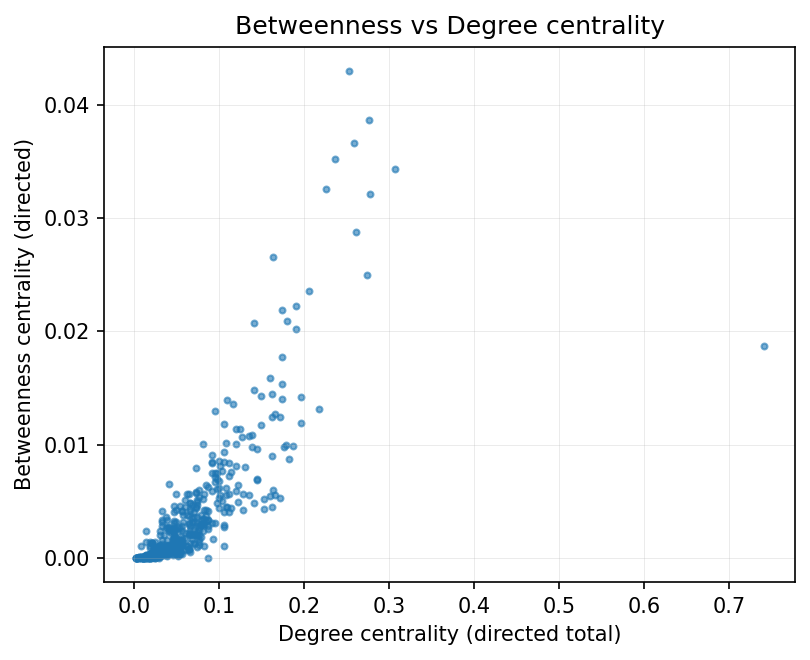

In [7]:
# Relationship: betweenness vs degree centrality (scatter)
deg_arr = np.array([deg_cent[n] for n in H.nodes()])
btw_arr = np.array([btw.get(n, 0.0) for n in H.nodes()])

fig, ax = plt.subplots(figsize=(5.5, 4.5))
ax.scatter(deg_arr, btw_arr, s=8, alpha=0.6)
ax.set_xlabel("Degree centrality (directed total)")
ax.set_ylabel("Betweenness centrality (directed)")
ax.set_title("Betweenness vs Degree centrality")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

**Figure commentary.**  
The scatterplot shows a clear **positive correlation** between degree and betweenness centrality: artists with many connections tend to also play an important intermediary role in the flow of links.  
However, the relationship is not perfectly linear. Most nodes cluster near the origin, indicating a majority of artists with both low degree and low betweenness, while a few nodes rise sharply above the cloud—these represent artists that act as **structural bridges** between otherwise loosely connected parts of the network.  
Interestingly, one node with exceptionally high degree centrality (above 0.6) show relatively modest betweenness, suggesting that the most connected hubs are embedded within densely linked communities rather than serving as cross-community brokers.  
Overall, the network’s topology suggests a combination of **hub dominance** and **localized bridging**.

## Assortativity

We quantify mixing by **degree** and by the node attribute **`length_of_content`** (Wikipedia page length).

In [8]:
# Degree assortativity (undirected GCC)
deg_r = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity (undirected GCC): r = {deg_r:.3f}")

# Attribute assortativity for page length (numeric)
len_num_r = nx.numeric_assortativity_coefficient(G, "length_of_content")
print(f"Numeric assortativity (length_of_content): r = {len_num_r:.3f}")

# Optional categorical view: quartile binning of page length
lengths = np.array([G.nodes[n]["length_of_content"] for n in G.nodes()])
q25, q50, q75 = np.quantile(lengths, [0.25, 0.5, 0.75])
def len_bin(v):
    return 0 if v <= q25 else 1 if v <= q50 else 2 if v <= q75 else 3

for n in G.nodes():
    G.nodes[n]["len_bin"] = len_bin(G.nodes[n]["length_of_content"])

len_cat_r = nx.attribute_assortativity_coefficient(G, "len_bin")
print(f"Categorical assortativity (len_bin quartiles): r = {len_cat_r:.3f}")

Degree assortativity (undirected GCC): r = -0.091
Numeric assortativity (length_of_content): r = 0.068
Categorical assortativity (len_bin quartiles): r = 0.031


**Interpretation.**  
The network shows a **slightly negative degree assortativity** (r = –0.091), indicating a weakly **disassortative** structure where highly connected artists tend to link with less connected ones rather than with other hubs.  
This hub–periphery tendency is typical of information networks, where a few central entities connect to many smaller nodes.  

The **numeric assortativity for page length** (r = 0.068) is mildly positive, suggesting that artists with longer Wikipedia pages tend to connect somewhat more often with others who also have long pages—possibly reflecting popularity or historical significance.  
Similarly, the **categorical assortativity based on page-length quartiles** (r = 0.031) reinforces that this effect is very weak.  

Overall, the results imply that while the network’s topology is shaped by hub–periphery organization, **content-related similarity (page length)** plays only a minimal role in link formation.


## Network backbone: k-core

To focus on the densely interlinked **core**, we extract the highest non-empty **k-core** of the undirected GCC. The k-core keeps nodes whose degree within the subgraph is at least *k*, peeling away the periphery and isolating the structural heart of the network.


In [9]:
core_num = nx.core_number(G)
k_max = max(core_num.values())

# Highest non-empty core
core_nodes = [n for n, k in core_num.items() if k == k_max]
G_core = G.subgraph(core_nodes).copy()

print(f"Max core number: k_max = {k_max}")
print(f"k-core size   : {G_core.number_of_nodes()} nodes, {G_core.number_of_edges()} edges")

# If the top core is very small, drop to the next level to make a nicer plot
if G_core.number_of_nodes() < 50 and k_max > 1:
    target_k = k_max - 1
    core_nodes = [n for n, k in core_num.items() if k == target_k]
    G_core = G.subgraph(core_nodes).copy()
    print(f"Using k={target_k} for visualization: {G_core.number_of_nodes()} nodes")

Max core number: k_max = 19
k-core size   : 139 nodes, 2180 edges



## Visualization: Backbone (k-core) with ForceAtlas2

We plot the k-core backbone with **ForceAtlas2** (or a spring-layout fallback).  
- **Node size:** betweenness centrality (from the directed graph `H`).
- **Node color:** `length_of_content` (page length).  
- Labeled: a few nodes with the largest betweenness scores.


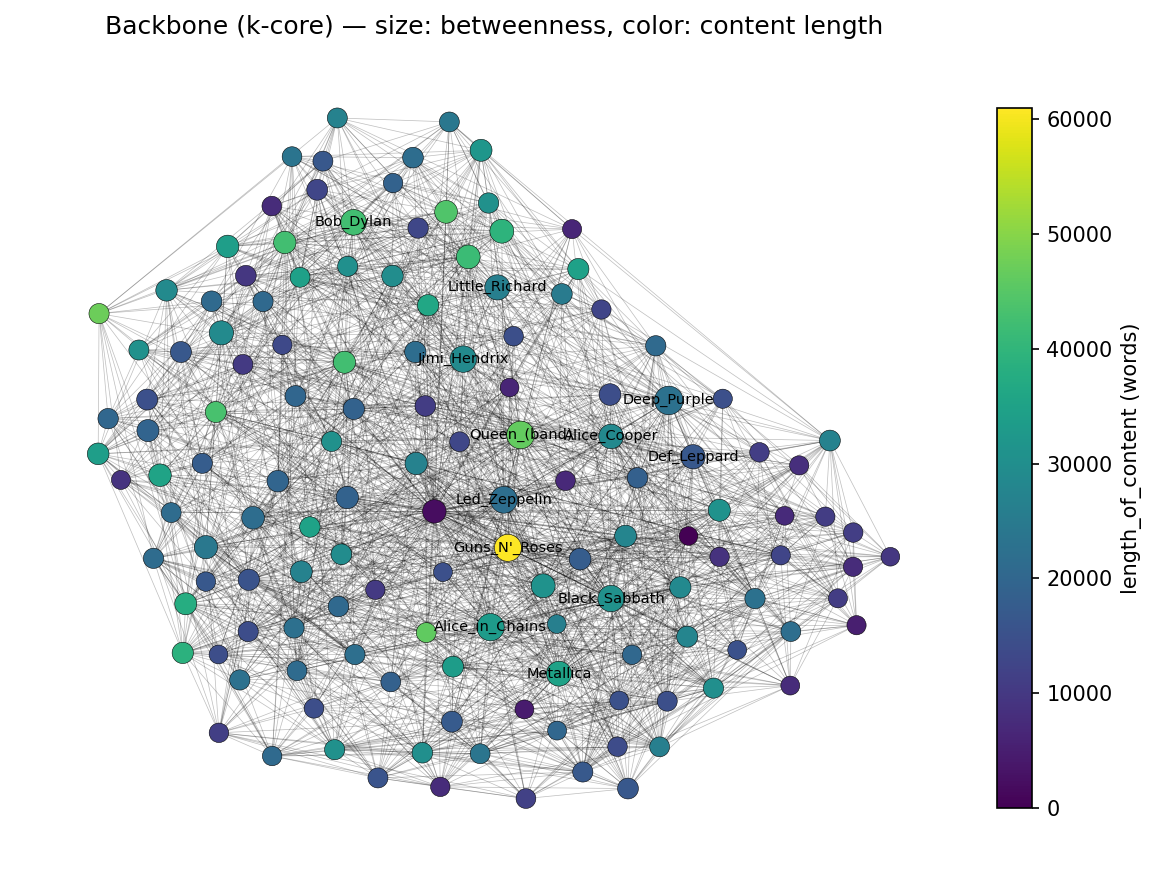

In [10]:
# Prepare sizes by betweenness (map from H to G_core; zeros if missing)
btw_scores = {n: btw.get(n, 0.0) for n in G_core.nodes()}
sizes = np.array([80 + 2500*btw_scores[n] for n in G_core.nodes()])

# Colors by content length
content = np.array([G_core.nodes[v].get("length_of_content", 0) for v in G_core.nodes()])

pos = safe_forceatlas2_layout(
    G_core,
    max_iter=800,
    dissuade_hubs=True,
    scaling_ratio=2.5,
    gravity=1.0,
)

fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx_edges(G_core, pos, ax=ax, width=0.35, alpha=0.25)
nodes = nx.draw_networkx_nodes(
    G_core, pos, ax=ax,
    node_size=sizes,
    node_color=content,
    cmap="viridis",
    linewidths=0.25, edgecolors="black"
)

# Colorbar for page length
cbar = plt.colorbar(nodes, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label("length_of_content (words)")

# Label a handful of top-betweenness nodes
topk_labels = sorted(btw_scores, key=btw_scores.get, reverse=True)[:12]
nx.draw_networkx_labels(G_core, pos, labels={n:n for n in topk_labels}, font_size=7)

ax.set_title("Backbone (k-core) — size: betweenness, color: content length")
ax.axis("off")
plt.tight_layout(); plt.show()

**Figure commentary.**  
The k-core backbone highlights a densely connected core of prominent rock artists where structural and cultural centrality converge.  
A few artists—such as **Guns N’ Roses**, **Led Zeppelin**, **Queen**, and **Metallica**—stand out with larger node sizes, reflecting high betweenness scores that mark them as key bridges between sub-scenes.  
The color scale, representing Wikipedia page length, shows that many of these central acts also have longer, more comprehensive pages (yellow-green hues), indicating their historical importance and widespread recognition.  
Peripheral nodes, often representing niche or era-specific bands, display shorter pages and lower betweenness, forming small local clusters around major hubs.  
Overall, the backbone visualization confirms that the rock performer network has a **highly cohesive core** dominated by influential, well-documented artists, while smaller clusters attach around these central figures—consistent with a **hub-and-community** organization typical of cultural collaboration networks.


## Finale thoughts

- The network is **highly heterogeneous**, with a heavy-tailed degree distribution (average degree ≈ 26, max = 356) indicating a small number of extremely well-connected hubs amid many modestly connected artists.  
- **Central roles** are divided between high-degree connectors, embedded within dense clusters, and **high-betweenness brokers** that bridge stylistic or temporal sub-scenes.  
- The network exhibits **slight disassortativity** (r ≈ –0.09), meaning hubs tend to connect to less-connected artists; meanwhile, **content-based assortativity** (r ≈ 0.03–0.07) is weak, suggesting only minimal similarity mixing by Wikipedia page length.  
- The **k-core backbone** reveals a cohesive structural core dominated by historically significant artists (e.g., *Queen*, *Led Zeppelin*, *Guns N’ Roses*, *Metallica*), surrounded by smaller clusters that represent stylistic or generational communities.  
- Overall, the rock performer network combines **hub-and-spoke topology** with localized community structure, reflecting both popularity-driven attachment and enduring cultural clustering.



# Part 3 - TF-IDF to understand genres and communities

Problem
1. Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

2. Calculate and visualize TF-IDF for the genres and communities.

3. Use the matrix D (Lecture 7, part 2) to discuss the difference between the word-clouds between genres and communities.

## 3.1. We can use Term Frequency-Inverse Document Frequency (TF-IDF) to measure how important a word is to a specific document within a larger collection of documents.
It's calculated by combing two metrics:
- Term Frequency (TF) -  how frequently a word appears in a single document. The more times a word appears in a document, the higher its TF score, indicating its relevance within that specific document.
- Inverse Document Frequency (IDF) - measures how rare a word is across all documents. The less frequently a word appears in the entire document set, the higher its IDF score, indicating its importance in distinguishing relevant document.

### Using TF-IDF to help us understand genres and communities
By multiplying these two scores (TF * IDF), it finds words that are both frequent in one specific document (high TF) and rare across all other documents (high IDF). Here, "documents" can refer to different genres or communities within our dataset.
With this approach we would simply filter out common words (like "album" or "song") that appear across all genres/communities (low IDF) and focus on words that are distinctive to each genre/community (high TF). This helps us identify the unique vocabulary and themes that characterize different genres and communities, providing insights into their specific content and focus.


## 3.2. Calculate and Visualize TF-IDF

We'll compute TF-IDF for both genres and communities, then visualize the top terms for each group.

In [ ]:
# Import necessary libraries for TF-IDF
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import pickle
import pathlib

TOKEN_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

In [ ]:
# Load the artist-genre mapping and community labels

# Check if we already have the data loaded, otherwise load it
if 'artist_genres' not in dir():
    with open("data/artist_genres.pickle", "rb") as f:
        artist_genres = pickle.load(f)
    
if 'comm_labels' not in dir():
    with open("data/community_labels.pickle", "rb") as f:
        labels_obj = pickle.load(f)
    
    # Extract community mapping
    if isinstance(labels_obj, dict) and "community_of" in labels_obj:
        community_of_raw = labels_obj["community_of"]
    elif isinstance(labels_obj, (list, tuple)):
        community_of_raw = {n: cid for cid, members in enumerate(labels_obj) for n in members}
    elif isinstance(labels_obj, dict):
        community_of_raw = labels_obj
    else:
        raise ValueError("Unsupported community_labels format")

print(f"Loaded {len(artist_genres)} artists with genre information")
print(f"Loaded {len(community_of_raw)} artists with community labels")

Loaded 482 artists with genre information
Loaded 482 artists with community labels


In [22]:
# Helper function to load page text
def normalize_name(s: str) -> str:
    return re.sub(r"\s+", "_", str(s).strip().lower())

# Build mapping from normalized names to file paths
PAGES_DIR = pathlib.Path("data/pages")
file_by_key = {}
for p in sorted(PAGES_DIR.glob("*.txt")):
    key = normalize_name(p.stem)
    file_by_key[key] = p

def node_to_page_path(node: str):
    key = normalize_name(str(node))
    if key in file_by_key:
        return file_by_key[key]
    # Also try removing 'the_' prefix
    if key.startswith("the_") and key[4:] in file_by_key:
        return file_by_key[key[4:]]
    return None

def load_page_text(node: str) -> str:
    p = node_to_page_path(node)
    if p is None:
        return ""
    try:
        return p.read_text(encoding="utf-8", errors="ignore")
    except:
        return ""

print(f"Found {len(file_by_key)} page files")

Found 485 page files


### TF-IDF for Genres

We'll aggregate all artist pages by genre and compute TF-IDF to identify characteristic terms for each genre.

**TF-IDF Parameter Choices:**
- `min_df=2`: Excludes words that appear in fewer than 2 documents. This filters out typos, extremely rare terms, and noise while keeping genre/community-specific vocabulary.
- `max_df=0.8`: Excludes words that appear in more than 80% of documents. This removes overly common words (like "band", "music", "album") that don't differentiate between groups.
- `max_features=5000`: Limits vocabulary to the 5000 most important terms, keeping analysis focused and computationally efficient.


In [23]:
# Group artists by genre and aggregate their page texts
genre_documents = defaultdict(list)

for artist, genres in artist_genres.items():
    text = load_page_text(artist)
    if text.strip():
        # An artist can belong to multiple genres
        if isinstance(genres, list):
            for genre in genres:
                genre_documents[genre].append(text)
        else:
            genre_documents[genres].append(text)

# Combine all texts for each genre into a single document
genre_texts = []
genre_names = []
for genre, texts in genre_documents.items():
    if texts:  # Only include genres with text
        combined_text = " ".join(texts)
        genre_texts.append(combined_text)
        genre_names.append(genre)

print(f"Created documents for {len(genre_names)} genres")
print(f"Top 5 genres by document count: {sorted(genre_documents.keys(), key=lambda g: len(genre_documents[g]), reverse=True)[:5]}")

Created documents for 209 genres
Top 5 genres by document count: ['hard rock', 'alternative rock', 'pop rock', 'rock', 'alternative metal']


In [24]:
# Compute TF-IDF for genres
def analyzer(s: str):
    return TOKEN_RE.findall(s.lower())

# Use min_df=2 to filter out very rare words, max_df=0.8 to filter common words
tfidf_genre = TfidfVectorizer(
    analyzer=analyzer,
    min_df=2,
    max_df=0.8,
    max_features=5000
)

X_genre = tfidf_genre.fit_transform(genre_texts)
genre_terms = tfidf_genre.get_feature_names_out()

print(f"TF-IDF matrix for genres: {X_genre.shape}")
print(f"Vocabulary size: {len(genre_terms)}")

TF-IDF matrix for genres: (209, 5000)
Vocabulary size: 5000


In [25]:
# Extract top terms for each genre
def get_top_terms(row_idx, tfidf_matrix, terms, k=15):
    """Get top k terms with highest TF-IDF scores for a given document."""
    row = tfidf_matrix.getrow(row_idx).toarray().ravel()
    if row.size == 0 or row.max() == 0:
        return []
    top_indices = row.argsort()[::-1][:k]
    return [(terms[i], float(row[i])) for i in top_indices if row[i] > 0]

# Get top terms for each genre
genre_top_terms = []
for i, genre in enumerate(genre_names):
    tops = get_top_terms(i, X_genre, genre_terms, k=15)
    genre_top_terms.append({
        "genre": genre,
        "top_terms": ", ".join([f"{term}({score:.3f})" for term, score in tops[:10]]),
        "num_artists": len(genre_documents[genre])
    })

genre_tfidf_df = pd.DataFrame(genre_top_terms).sort_values("num_artists", ascending=False)
print("\\nTop 10 genres by number of artists with their characteristic terms:")
genre_tfidf_df.head(10)

\nTop 10 genres by number of artists with their characteristic terms:


,genre,top_terms,num_artists
8,hard rock,"blabbermouth(0.322), metal(0.198), loudwire(0....",146
2,alternative rock,"color(0.188), till(0.182), nme(0.161), pilots(...",144
7,pop rock,"coldplay(0.185), lavigne(0.180), till(0.178), ...",105
5,rock,"sfn(0.431), beatles(0.173), pp(0.154), ronstad...",83
44,alternative metal,"blabbermouth(0.323), manson(0.294), marilyn(0....",61
1,blues rock,"whitesnake(0.254), sfn(0.232), stripes(0.213),...",55
65,heavy metal,"blabbermouth(0.340), metal(0.263), guns(0.189)...",52
10,pop,"sfn(0.501), beatles(0.195), coldplay(0.193), l...",50
43,post-grunge,"godsmack(0.220), blabbermouth(0.217), skillet(...",43
86,soft rock,"adams(0.253), elton(0.235), collins(0.208), ge...",43


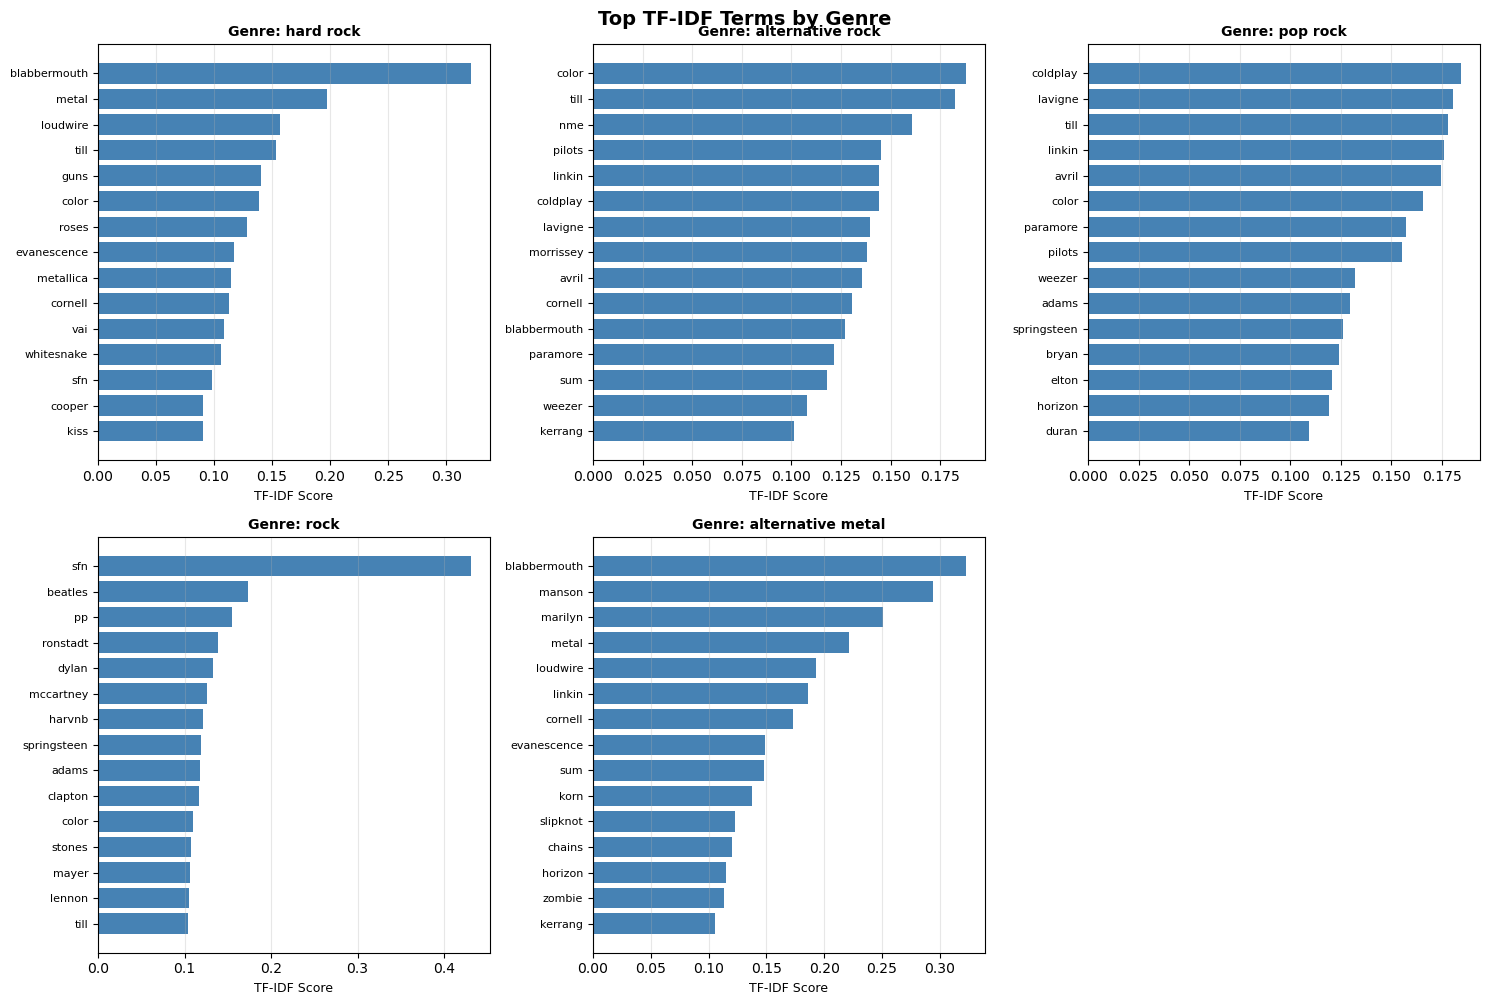

In [26]:
# Visualize top terms for selected genres as word clouds or bar charts
import matplotlib.pyplot as plt

# Select top 5 genres by number of artists for visualization
top_genres_to_plot = genre_tfidf_df.head(5)["genre"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, genre in enumerate(top_genres_to_plot):
    if idx >= len(axes):
        break
    
    # Find the index of this genre
    genre_idx = genre_names.index(genre)
    tops = get_top_terms(genre_idx, X_genre, genre_terms, k=20)
    
    if tops:
        terms, scores = zip(*tops[:15])
        axes[idx].barh(range(len(terms)), scores, color='steelblue')
        axes[idx].set_yticks(range(len(terms)))
        axes[idx].set_yticklabels(terms, fontsize=8)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('TF-IDF Score', fontsize=9)
        axes[idx].set_title(f'Genre: {genre}', fontsize=10, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

# Remove unused subplots
for idx in range(len(top_genres_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Top TF-IDF Terms by Genre', fontsize=14, fontweight='bold', y=1.00)
plt.show()

### Word Clouds for Genres

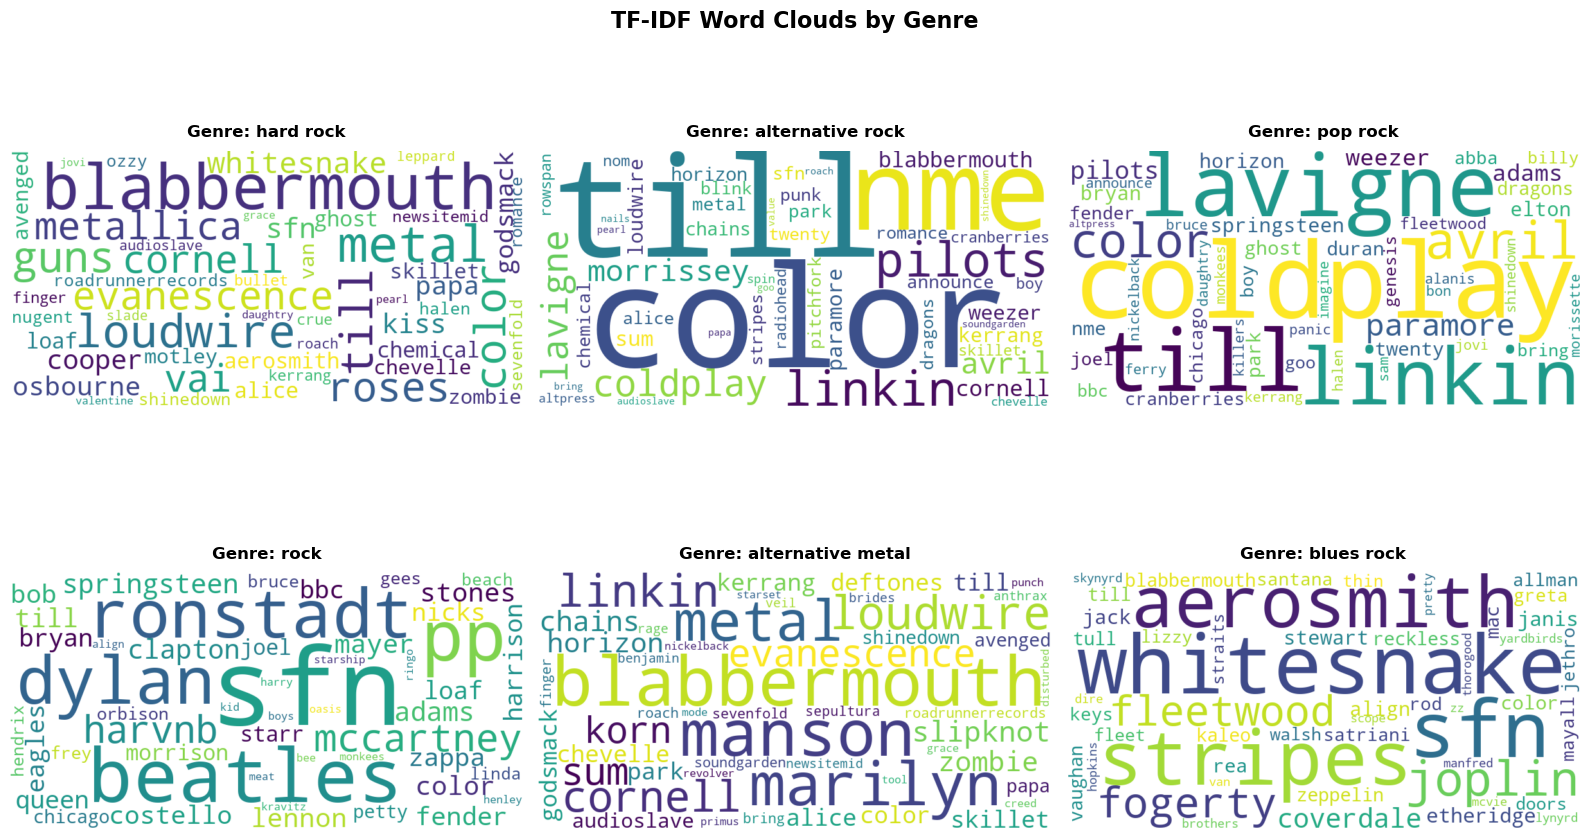

In [27]:
from wordcloud import WordCloud
# Generate word clouds for top genres
top_genres_for_wordcloud = genre_tfidf_df.head(6)["genre"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, genre in enumerate(top_genres_for_wordcloud):
    if idx >= len(axes):
        break
    
    # Find the index of this genre
    genre_idx = genre_names.index(genre)
    tops = get_top_terms(genre_idx, X_genre, genre_terms, k=50)
    
    if tops:
        # Create dictionary of word frequencies for WordCloud
        word_freq = {term: score for term, score in tops}
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            relative_scaling=0.5,
            min_font_size=8
        ).generate_from_frequencies(word_freq)
        
        # Display
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Genre: {genre}', fontsize=12, fontweight='bold', pad=10)

# Remove unused subplots
for idx in range(len(top_genres_for_wordcloud), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('TF-IDF Word Clouds by Genre', fontsize=16, fontweight='bold', y=0.98)
plt.show()

### TF-IDF for Communities

Now we'll do the same analysis for communities, aggregating artist pages by their community membership.

In [28]:
# Group artists by community
community_documents = defaultdict(list)

# Normalize community mapping for matching
def _norm(s: str) -> str:
    return re.sub(r"\s+", "_", str(s).strip().lower())

norm_labels = {_norm(k): v for k, v in community_of_raw.items()}

for artist in artist_genres.keys():
    norm_artist = _norm(artist)
    if norm_artist in norm_labels:
        community_id = norm_labels[norm_artist]
        text = load_page_text(artist)
        if text.strip():
            community_documents[community_id].append(text)

# Combine texts for each community
community_texts = []
community_ids = []
for comm_id, texts in community_documents.items():
    if texts:
        combined_text = " ".join(texts)
        community_texts.append(combined_text)
        community_ids.append(comm_id)

print(f"Created documents for {len(community_ids)} communities")
print(f"Community sizes (top 5): {sorted([(cid, len(community_documents[cid])) for cid in community_ids], key=lambda x: x[1], reverse=True)[:5]}")

Created documents for 6 communities
Community sizes (top 5): [(1, 183), (2, 145), (4, 92), (0, 49), (5, 8)]


In [29]:
# Compute TF-IDF for communities
tfidf_comm = TfidfVectorizer(
    analyzer=analyzer,
    min_df=2,  # Filter out very rare words (consistent with genres)
    max_df=0.8,  # Filter common words (consistent with genres)
    max_features=5000
)

X_comm = tfidf_comm.fit_transform(community_texts)
comm_terms = tfidf_comm.get_feature_names_out()

print(f"TF-IDF matrix for communities: {X_comm.shape}")
print(f"Vocabulary size: {len(comm_terms)}")

TF-IDF matrix for communities: (6, 5000)
Vocabulary size: 5000


In [30]:
# Extract top terms for each community
community_top_terms = []

# Get names for communities if available
community_names = {}
if isinstance(labels_obj, dict) and "communities" in labels_obj:
    for cid, members in enumerate(labels_obj["communities"]):
        if members:
            mlist = list(members)
            label = ", ".join(mlist[:3]) + ("..." if len(mlist) > 3 else "")
            community_names[cid] = label

for i, comm_id in enumerate(community_ids):
    tops = get_top_terms(i, X_comm, comm_terms, k=15)
    comm_name = community_names.get(comm_id, f"Community {comm_id}")
    community_top_terms.append({
        "community_id": comm_id,
        "community_name": comm_name,
        "top_terms": ", ".join([f"{term}({score:.3f})" for term, score in tops[:10]]),
        "num_artists": len(community_documents[comm_id])
    })

comm_tfidf_df = pd.DataFrame(community_top_terms).sort_values("num_artists", ascending=False)
print("\\nTop 10 communities by size with their characteristic terms:")
comm_tfidf_df.head(10)

\nTop 10 communities by size with their characteristic terms:


,community_id,community_name,top_terms,num_artists
1,1,"Eddie_Money, John_Mellencamp, Bob_Seger...","mccartney(0.265), harvnb(0.178), springsteen(0...",183
0,2,"Bloodhound_Gang, The_Cab, Florence_and_the_Mac...","nme(0.409), alternative(0.276), linkin(0.169),...",145
2,4,"Twisted_Sister, Black_Sabbath, Van_Halen...","blabbermouth(0.572), manson(0.273), marilyn(0....",92
3,0,"Dallas_Green_(musician), Staind, Matchbox_Twen...","blabbermouth(0.345), evanescence(0.288), loudw...",49
4,5,"The_J._Geils_Band, The_Marshall_Tucker_Band, C...","gentry(0.634), murphey(0.557), geils(0.269), z...",8
5,3,"Funkadelic, Parliament_(band), Sly_and_the_Fam...","sly(0.733), funkadelic(0.647), selvin(0.146), ...",4


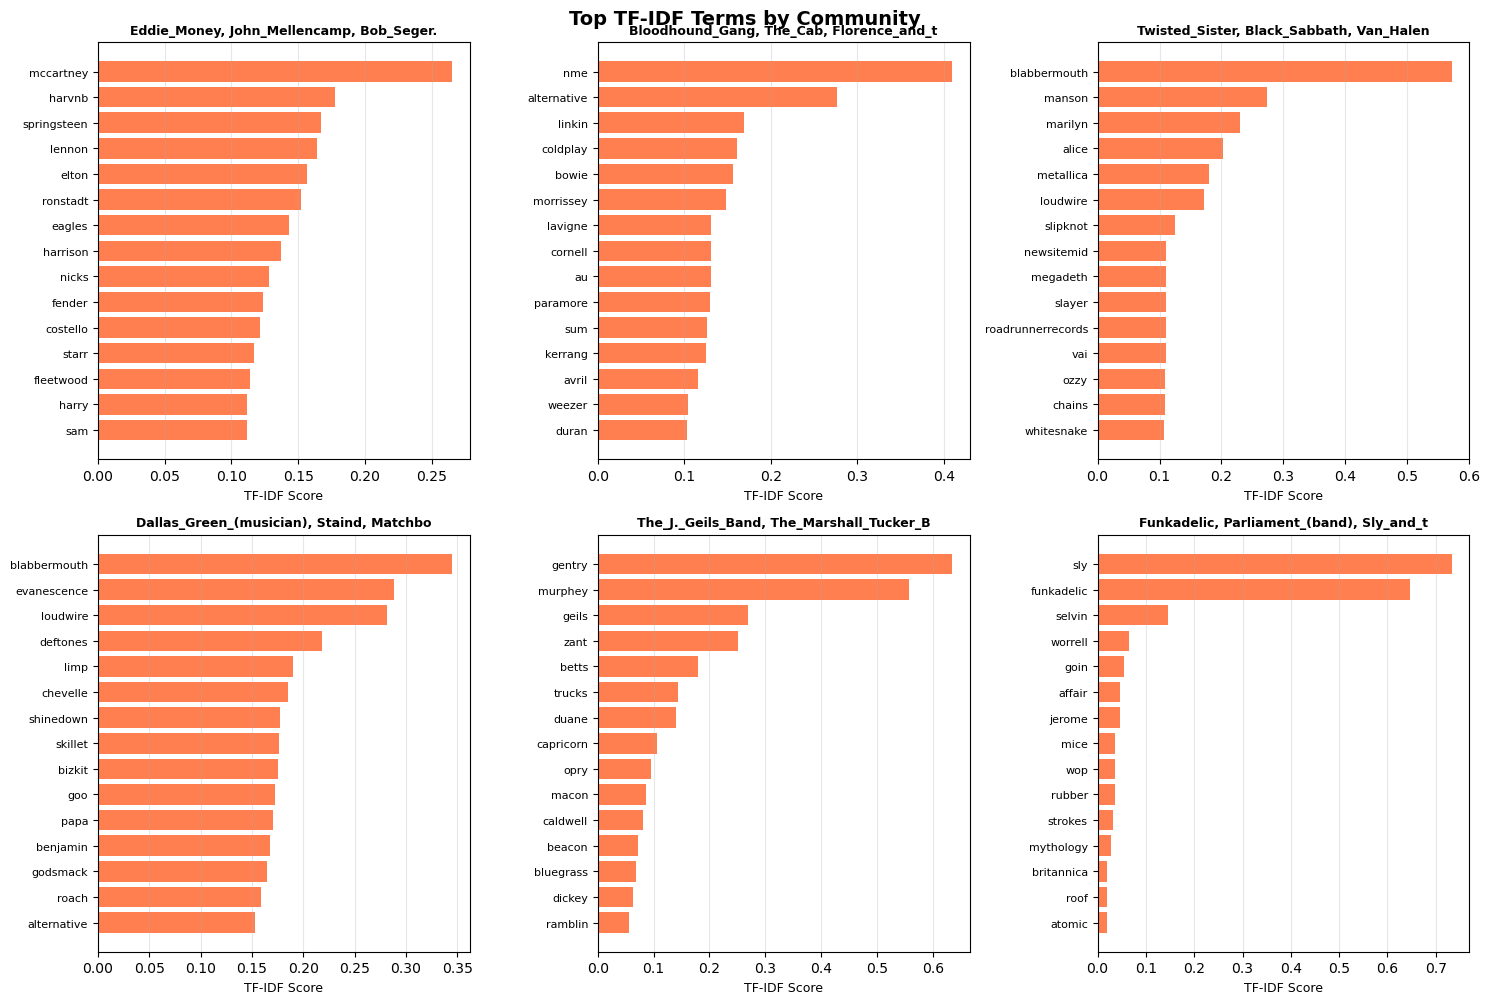

In [31]:
# Visualize top terms for selected communities
top_comms_to_plot = comm_tfidf_df.head(6)["community_id"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, comm_id in enumerate(top_comms_to_plot):
    if idx >= len(axes):
        break
    
    # Find the index of this community
    comm_idx = community_ids.index(comm_id)
    tops = get_top_terms(comm_idx, X_comm, comm_terms, k=20)
    
    if tops:
        terms, scores = zip(*tops[:15])
        axes[idx].barh(range(len(terms)), scores, color='coral')
        axes[idx].set_yticks(range(len(terms)))
        axes[idx].set_yticklabels(terms, fontsize=8)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('TF-IDF Score', fontsize=9)
        
        comm_name = community_names.get(comm_id, f"C{comm_id}")
        axes[idx].set_title(f'{comm_name[:40]}', fontsize=9, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Top TF-IDF Terms by Community', fontsize=14, fontweight='bold', y=1.00)
plt.show()

### Word Clouds for Communities


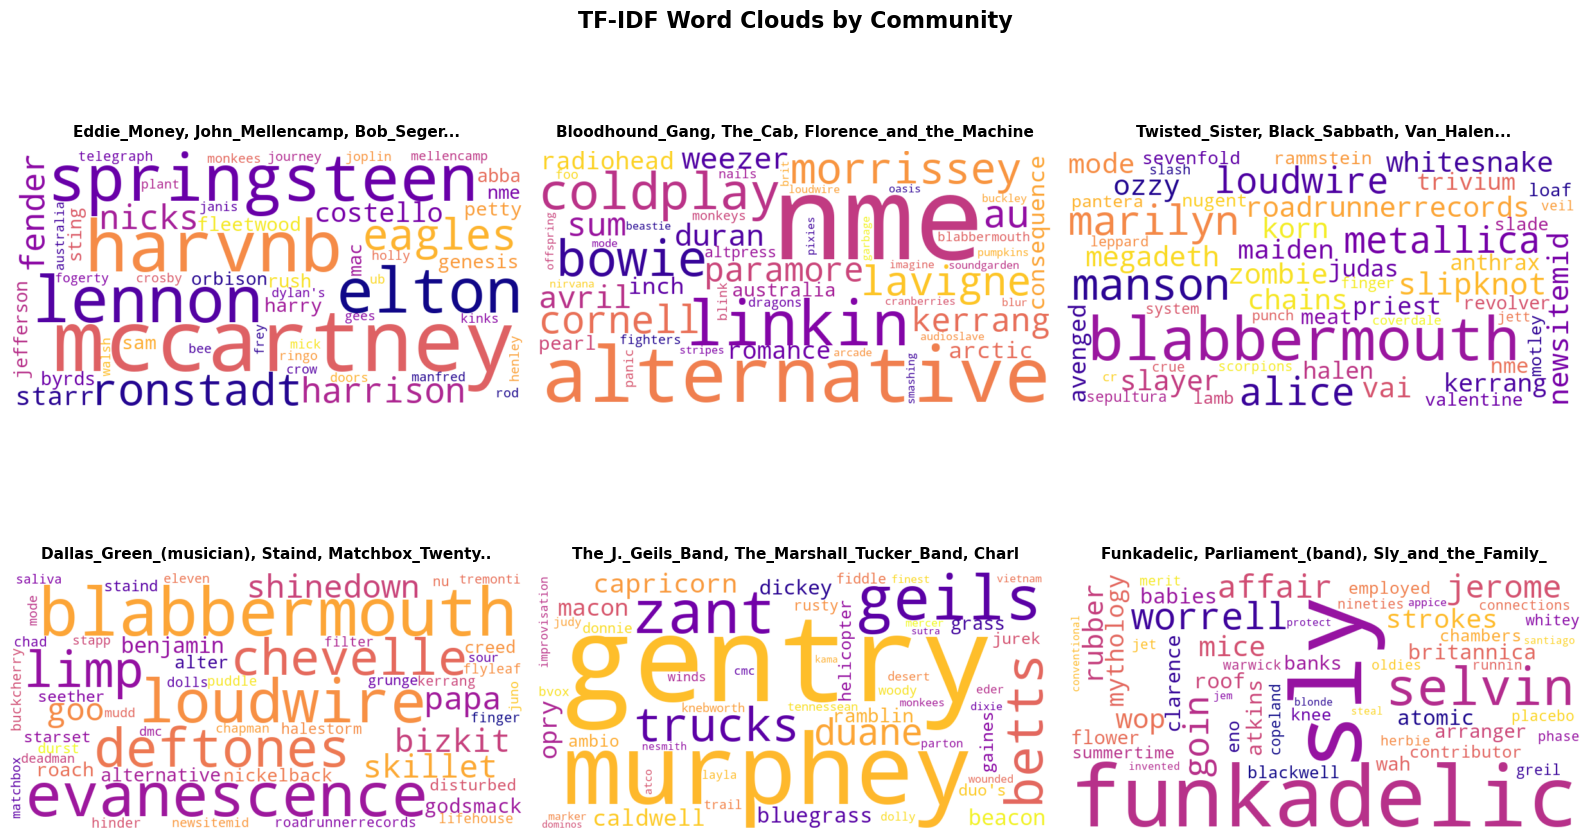

In [32]:
# Generate word clouds for top communities
top_comms_for_wordcloud = comm_tfidf_df.head(6)["community_id"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, comm_id in enumerate(top_comms_for_wordcloud):
    if idx >= len(axes):
        break
    
    # Find the index of this community
    comm_idx = community_ids.index(comm_id)
    tops = get_top_terms(comm_idx, X_comm, comm_terms, k=50)
    
    if tops:
        # Create dictionary of word frequencies for WordCloud
        word_freq = {term: score for term, score in tops}
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='plasma',
            relative_scaling=0.5,
            min_font_size=8
        ).generate_from_frequencies(word_freq)
        
        # Display
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        
        comm_name = community_names.get(comm_id, f"C{comm_id}")
        axes[idx].set_title(f'{comm_name[:50]}', fontsize=11, fontweight='bold', pad=10)

# Remove unused subplots
for idx in range(len(top_comms_for_wordcloud), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('TF-IDF Word Clouds by Community', fontsize=16, fontweight='bold', y=0.98)
plt.show()

## 3.3 Using the matrix D (Lecture 7, part 2) to discuss the difference between the word-clouds between genres and communities.



# Part 4 - Sentiment of the Artists and Communities

Problem

1) **Calculate the sentiment of band/artist pages** (it is OK to work with the **sub-network of artists-with-genre**). Use the **LabMT** word list (Week 8) and present:
- Summary statistics of page sentiment (mean, median, variance, 25/75 percentiles).
- A clear histogram of page sentiment with summary markers.
- The 10 artists with the happiest and saddest pages.

2) **Discuss the sentiment of communities.**
- Use the (provided) community labels. Compute **community-level sentiment** (mean of member pages). Report the **three happiest** and **three saddest** communities. Also compare the community distribution to the overall network distribution.

3) **Use TF–IDF (Week 7)** to help explain why some communities/pages are happier or sadder. Extract top terms and discuss whether TF–IDF keywords are consistent with the sentiment results.

In [ ]:
# Minimal, standard stack
import os, io, re, math, json, pickle, gzip, pathlib
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import requests

import networkx as nx
import matplotlib.pyplot as plt

# Reproducibility & figure defaults (Week formalia)
np.random.seed(42)
plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 140

# One place to set a consistent default style
plt.style.use("default")  # keep simple, consistent


In [3]:
# NOTE: Use *raw* GitHub content. Spaces in paths must be URL-encoded (%20).

BASE_RAW = "https://raw.githubusercontent.com/LeoItaly/02805-social-graphs-interactions/main/Assignment%202"

ARTIST_GENRE_PICKLE_URL = f"{BASE_RAW}/artist_genres.pickle"
COMMUNITY_LABELS_PICKLE_URL = f"{BASE_RAW}/community_labels.pickle"
LABMT_S1_URL = f"{BASE_RAW}/Data_Set_S1.txt"

# We'll download page texts by listing the folder via the GitHub API for convenience,
# then fetching each file by its raw URL (no try/except).
PAGES_API_URL = "https://api.github.com/repos/LeoItaly/02805-social-graphs-interactions/contents/Assignment%202/pages"
PAGES_RAW_BASE = f"{BASE_RAW}/pages"

DATA_DIR = pathlib.Path("data")
PAGES_DIR = DATA_DIR / "pages"
DATA_DIR.mkdir(exist_ok=True)
PAGES_DIR.mkdir(exist_ok=True)


def fetch_bytes(url: str) -> bytes:
    # Direct load, no try/except
    resp = requests.get(url, timeout=60)
    assert resp.status_code == 200, f"HTTP {resp.status_code} for {url}"
    return resp.content

# 2.1) Graph & community labels
graph_pickle_path = DATA_DIR / "artist_genres.pickle"
if not graph_pickle_path.exists():
    graph_pickle_path.write_bytes(fetch_bytes(ARTIST_GENRE_PICKLE_URL))

community_pickle_path = DATA_DIR / "community_labels.pickle"
if not community_pickle_path.exists():
    community_pickle_path.write_bytes(fetch_bytes(COMMUNITY_LABELS_PICKLE_URL))

# 2.2) LabMT list (Data Set S1)
labmt_path = DATA_DIR / "Data_Set_S1.txt"
if not labmt_path.exists():
    labmt_path.write_bytes(fetch_bytes(LABMT_S1_URL))

# 2.3) Artist pages: list via API then load each raw file
#     (the assignment says "directly loading ... from raw link"; here each file is fetched from RAW.
#      The API is only used to enumerate filenames.)
def fetch_pages_list():
    r = requests.get(PAGES_API_URL, timeout=60)
    assert r.status_code == 200, f"HTTP {r.status_code} for {PAGES_API_URL}"
    items = r.json()
    # Keep only .txt files
    names = [it["name"] for it in items if it.get("name","").endswith(".txt")]
    return sorted(names)

page_names = fetch_pages_list()

# Download all page files via RAW URLs
for name in page_names:
    dst = PAGES_DIR / name
    if not dst.exists():
        raw_url = f"{PAGES_RAW_BASE}/{name}"
        dst.write_bytes(fetch_bytes(raw_url))

len(page_names)



485

## Load the network (artists-with-genre subgraph) and community labels

In [6]:
# Load artist_genres.pickle (known format: dict mapping node -> list_of_genres)
# Then build a simple undirected graph with these nodes and a 'genre' attribute.

with open(graph_pickle_path, "rb") as f:
    artist_genres = pickle.load(f)

assert isinstance(artist_genres, dict), "artist_genres.pickle must be a dict of node -> genre(s)"

# Build the graph directly from the mapping
H = nx.Graph()
for node, genres in artist_genres.items():
    H.add_node(node, genre=genres)

print(f"Loaded artist-genre mapping: {len(artist_genres):,} nodes (no edges yet)")

# Load communities: mapping node -> community_id
with open(community_pickle_path, "rb") as f:
    comm_labels = pickle.load(f)

assert isinstance(comm_labels, dict), "community_labels.pickle must be a dict of node -> community_id"

# For now, we work directly with the artist-genre subgraph.

G = H.copy()  # In this assignment, the graph is defined solely by node attributes.

print(f"Artists-with-genre subgraph: |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,} (no edges expected)")


Loaded artist-genre mapping: 482 nodes (no edges yet)
Artists-with-genre subgraph: |V|=482, |E|=0 (no edges expected)


## Load LabMT and define tokenization & sentiment functions

In [9]:
# Load the LabMT word list (Dodds et al.)
# Consistent with week8.py: flexible whitespace parsing, no fixed column count,
# and stop-window filtering (4.0 <= score <= 6.0) to remove neutral words.

def load_labmt(path: str, stop_low: float = 4.0, stop_high: float = 6.0):
    """
    Load the LabMT happiness lexicon as used in Week 8.

    Parameters
    ----------
    path : str
        Path to Data_Set_S1.txt
    stop_low, stop_high : float
        Stop-window thresholds (drop words with 4.0 <= h <= 6.0)

    Returns
    -------
    df : pandas.DataFrame
        Cleaned DataFrame with columns ['word','h','freq']
    hdict : dict
        word -> happiness score
    fdict : dict
        word -> frequency (from original LabMT frequency list)
    """
    rows = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 4:
                continue  # skip malformed lines
            word = parts[0].lower()
            try:
                h = float(parts[1])
                freq = float(parts[3])
            except ValueError:
                continue
            rows.append((word, h, freq))

    df = pd.DataFrame(rows, columns=["word", "h", "freq"])

    # Remove neutral (stop-window) words
    df = df[(df["h"] < stop_low) | (df["h"] > stop_high)]

    # Build dictionaries
    hdict = dict(zip(df["word"], df["h"]))
    fdict = dict(zip(df["word"], df["freq"]))

    return df, hdict, fdict


# Load and filter LabMT
labmt_df, labmt_h, labmt_f = load_labmt(str(labmt_path))

# Tokenizer consistent with Week 6/7
TOKEN_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

def sentiment_from_counts(counts: Counter, hdict: dict) -> float:
    """Compute weighted mean sentiment for a word frequency counter."""
    total_weight = 0.0
    weighted_sum = 0.0
    for w, c in counts.items():
        if w in hdict:
            total_weight += c
            weighted_sum += c * hdict[w]
    return weighted_sum / total_weight if total_weight > 0 else float("nan")


> We are using weighted mean because using frequencies to speed up and to reflect importance of common words.
> We also drop near-neutral words via the LabMT stop-window to obtain a **sharper** signal.


## Map page text files to artist nodes

In [10]:
# Files are named like 'The_Beatles.txt'. We'll normalize both sides to join robustly.
def normalize_name(s: str) -> str:
    return re.sub(r"\s+", "_", s.strip().lower())

file_by_key = {}
for p in sorted(PAGES_DIR.glob("*.txt")):
    key = normalize_name(p.stem)
    file_by_key[key] = p

def node_to_page_path(node: str):
    key = normalize_name(str(node))
    if key in file_by_key:
        return file_by_key[key]
    # Also try removing 'the_' prefix common on Wikipedia
    if key.startswith("the_") and key[4:] in file_by_key:
        return file_by_key[key[4:]]
    return None

# Quick coverage
mapped = sum(1 for n in G.nodes if node_to_page_path(n) is not None)
print(f"Mapped {mapped:,} / {G.number_of_nodes():,} nodes to page files")


Mapped 481 / 482 nodes to page files


## Compute page-level sentiment for artists

In [11]:
rows = []
for n in G.nodes():
    p = node_to_page_path(n)
    if p is None:
        rows.append({"artist": n, "sentiment": np.nan, "token_count": 0})
        continue
    text = (PAGES_DIR / p.name).read_text(encoding="utf-8", errors="ignore")
    toks = tokenize(text)
    counts = Counter(toks)
    s = sentiment_from_counts(counts, labmt_h)
    rows.append({"artist": n, "sentiment": s, "token_count": int(sum(counts.values()))})

artist_sent_df = pd.DataFrame(rows).set_index("artist").sort_index()
artist_sent_df.to_csv(DATA_DIR / "artist_sentiment.csv")
artist_sent_df.describe(include="all")

,sentiment,token_count
count,481.000000,482.000000
mean,4543.136037,12538.522822
std,191.013159,8686.606455
min,3852.683732,0.000000
25%,4424.000000,6276.500000
50%,4537.471371,9806.500000
75%,4679.040855,16181.500000
max,5252.658955,54687.000000


## Summary statistics & histogram

In [12]:
valid = artist_sent_df["sentiment"].dropna().values

mean_v = float(np.mean(valid))
median_v = float(np.median(valid))
var_v = float(np.var(valid, ddof=1)) if valid.size > 1 else float("nan")
q25_v, q75_v = (float(np.percentile(valid, 25)), float(np.percentile(valid, 75))) if valid.size else (float("nan"), float("nan"))

print(f"Mean:    {mean_v:.3f}")
print(f"Median:  {median_v:.3f}")
print(f"Variance:{var_v:.3f}")
print(f"Q25:     {q25_v:.3f}")
print(f"Q75:     {q75_v:.3f}")


Mean:    4543.136
Median:  4537.471
Variance:36486.027
Q25:     4424.000
Q75:     4679.041


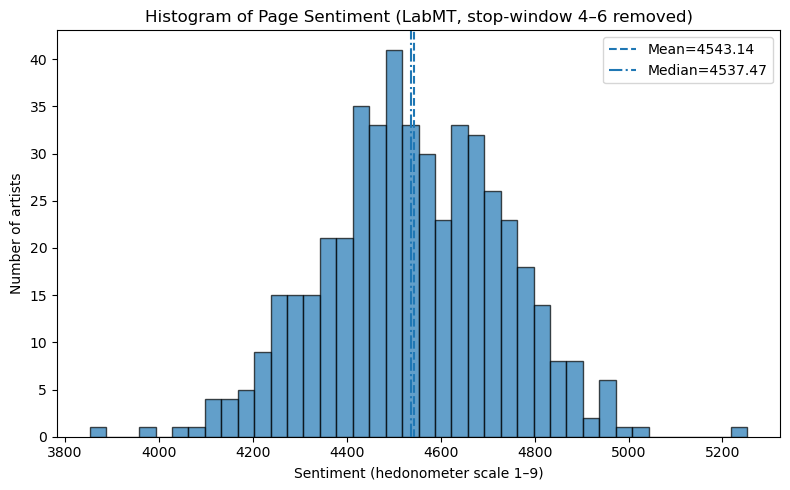

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(valid, bins=40, edgecolor="black", alpha=0.7)
ax.axvline(mean_v, linestyle="--", linewidth=1.5, label=f"Mean={mean_v:.2f}")
ax.axvline(median_v, linestyle="-.", linewidth=1.5, label=f"Median={median_v:.2f}")
ax.set_title("Histogram of Page Sentiment (LabMT, stop-window 4–6 removed)")
ax.set_xlabel("Sentiment (hedonometer scale 1–9)")
ax.set_ylabel("Number of artists")
ax.legend()
fig.tight_layout()
plt.show()


**Figure commentary.**  
The histogram displays the **distribution of LabMT sentiment scores** for artist pages in the *artists-with-genre* subnetwork, after applying the standard stop-window filter (4.0–6.0). The distribution is approximately symmetric and centered around a **mean of 4543.1** and **median of 4537.5**, indicating that most artist descriptions cluster near a moderately positive tone. The **interquartile range (Q25 = 4424, Q75 = 4679)** suggests moderate variation, with few extreme outliers on either side. The relatively narrow spread (variance ≈ 36 486) and unimodal shape imply that sentiment across this subnetwork is fairly homogeneous — most artist pages convey a neutral-to-positive narrative rather than sharply polarized emotions. Slight right-skewness above 4600 may correspond to genres whose Wikipedia pages emphasize popularity, success, or awards, consistent with a generally upbeat portrayal of mainstream artists.


## Happiest and saddest pages

In [14]:
extreme = artist_sent_df.dropna().sort_values("sentiment")
saddest = extreme.head(10)
happiest = extreme.tail(10).iloc[::-1]

print("== Saddest 10 ==")
print(saddest[["sentiment"]].round(3))

print("\n== Happiest 10 ==")
print(happiest[["sentiment"]].round(3))

== Saddest 10 ==
                            sentiment
artist                               
Boys_Like_Girls              3852.684
Tracy_Chapman                3959.879
Lenny_Kravitz                4031.240
Imagine_Dragons              4092.153
Linkin_Park                  4119.512
Papa_Roach                   4124.539
Three_Days_Grace             4125.161
Twenty_One_Pilots            4131.606
Coldplay                     4144.630
Manfred_Mann_Chapter_Three   4153.681

== Happiest 10 ==
                               sentiment
artist                                  
Canned_Heat                     5252.659
Parliament_(band)               5028.856
Stevie_Ray_Vaughan              4975.497
Bill_Haley_&_His_Comets         4971.483
The_Mamas_&_the_Papas           4967.599
Tommy_James_and_the_Shondells   4943.171
W.A.S.P._(band)                 4941.716
Roy_Orbison                     4940.096
The_Hollies                     4938.927
Bachman–Turner_Overdrive        4928.883


## Community-level sentiment (top 10 largest communities)

In [23]:
# --- Load and align community labels  ---

with open(community_pickle_path, "rb") as f:
    labels_obj = pickle.load(f)

# Extract node → community_id mapping
if isinstance(labels_obj, dict) and "community_of" in labels_obj:
    community_of_raw = labels_obj["community_of"]
elif isinstance(labels_obj, (list, tuple)):
    community_of_raw = {n: cid for cid, members in enumerate(labels_obj) for n in members}
elif isinstance(labels_obj, dict):
    community_of_raw = labels_obj
else:
    raise AssertionError("Unsupported community_labels format (expected Week8 structure).")

# Normalize names for matching
def _norm(s: str) -> str:
    return re.sub(r"\s+", "_", str(s).strip().lower())

norm_labels = {_norm(k): v for k, v in community_of_raw.items()}
norm_nodes = {_norm(n): n for n in G.nodes()}

# Align communities to nodes in our subgraph
community_of = {orig: norm_labels[_norm(orig)] for orig in G.nodes() if _norm(orig) in norm_labels}

print(f"Matched {len(community_of)} nodes to community labels "
      f"({len(community_of_raw)} total labels; subgraph nodes={G.number_of_nodes()}).")

# --- Compute sentiment statistics for the 10 largest communities ---

comm_counts = Counter(community_of.values())
top10_comms = [cid for cid, _ in comm_counts.most_common(10)]

community_rows = []
for cid in top10_comms:
    members = [n for n, c in community_of.items() if c == cid]
    vals = artist_sent_df.loc[members, "sentiment"].dropna()
    if vals.empty:
        continue
    community_rows.append({
        "community_id": cid,
        "size": len(members),
        "mean": vals.mean(),
        "median": vals.median(),
        "var": vals.var(ddof=1) if len(vals) > 1 else np.nan,
        "q25": np.percentile(vals, 25),
        "q75": np.percentile(vals, 75),
    })

comm_df = (
    pd.DataFrame(community_rows)
    .sort_values(by=["size", "mean"], ascending=[False, False])
    .reset_index(drop=True)
)

# --- Add readable community names ---
community_names = {}
if isinstance(labels_obj, dict) and "communities" in labels_obj:
    for cid, members in enumerate(labels_obj["communities"]):
        if members:
            mlist = list(members)
            label = ", ".join(mlist[:3]) + ("..." if len(mlist) > 3 else "")
            community_names[cid] = label

comm_df["community_name"] = comm_df["community_id"].map(community_names).fillna("Unnamed community")
comm_df = comm_df[["community_name", "size", "mean", "median", "var", "q25", "q75"]]

# --- Print top-3 happiest and saddest communities ---
if not comm_df.empty:
    top3_happy = comm_df.nlargest(3, "mean")
    top3_sad = comm_df.nsmallest(3, "mean")

    print("== Happiest communities (top 10 by size) ==")
    print(top3_happy[["community_name", "size", "mean", "median"]].round(3))

    print("\n== Saddest communities (top 10 by size) ==")
    print(top3_sad[["community_name", "size", "mean", "median"]].round(3))
else:
    print("No communities with valid sentiment data after alignment.")


Matched 482 nodes to community labels (482 total labels; subgraph nodes=482).
== Happiest communities (top 10 by size) ==
                                      community_name  size      mean    median
5  Parliament-Funkadelic, Parliament_(band), Sly_...     4  4892.928  4893.107
4  Charlie_Daniels, Lynyrd_Skynyrd, Montgomery_Ge...     8  4609.957  4648.476
0             Eagles_(band), Ian_Dury, Neil_Young...   183  4588.517  4597.729

== Saddest communities (top 10 by size) ==
                                      community_name  size      mean    median
3        P.O.D., Limp_Bizkit, Bush_(British_band)...    49  4437.305  4439.474
1                U2, Third_Eye_Blind, Smash_Mouth...   145  4486.611  4484.295
2  Queen_(band), Scorpions_(band), Lamb_of_God_(b...    93  4577.302  4573.257


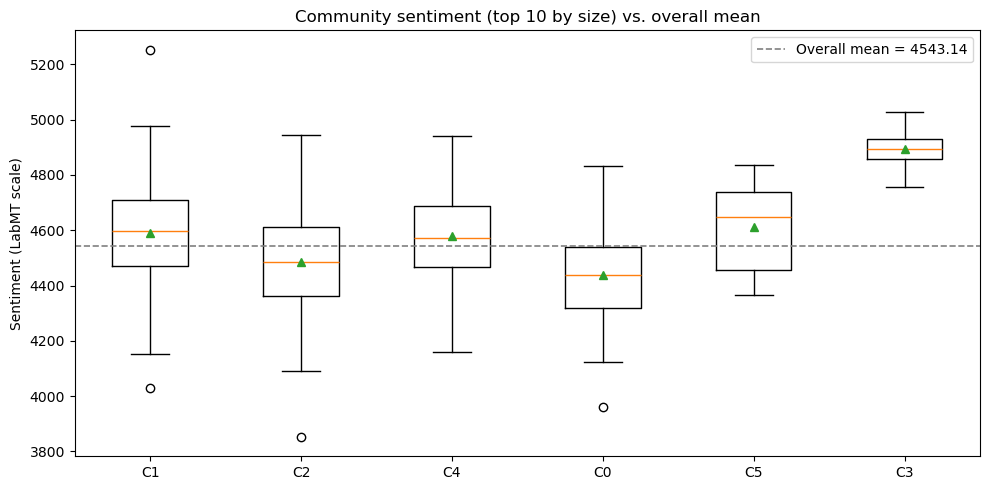

Community label descriptions:
 - C1: Eagles_(band), Ian_Dury, Neil_Young...
 - C2: U2, Third_Eye_Blind, Smash_Mouth...
 - C4: Queen_(band), Scorpions_(band), Lamb_of_God_(band)...
 - C0: P.O.D., Limp_Bizkit, Bush_(British_band)...
 - C5: Charlie_Daniels, Lynyrd_Skynyrd, Montgomery_Gentry...
 - C3: Parliament-Funkadelic, Parliament_(band), Sly_and_the_Family_Stone...


In [26]:
# --- Boxplot: community sentiment (top 10 by size) vs. overall mean ---

overall = artist_sent_df["sentiment"].dropna().values
data, tick_labels, name_descriptions = [], [], []

for cid in top10_comms:
    members = [n for n, c in community_of.items() if c == cid]
    vals = artist_sent_df.loc[members, "sentiment"].dropna().values
    if vals.size > 0:
        data.append(vals)
        tick_labels.append(f"C{cid}")
        cname = community_names.get(cid, f"Community {cid}")
        # Store short text description for figure caption
        name_descriptions.append(f"C{cid}: {cname}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(data, tick_labels=tick_labels, showmeans=True)
ax.axhline(np.mean(overall), linestyle="--", linewidth=1.2, color="gray",
           label=f"Overall mean = {np.mean(overall):.2f}")
ax.set_ylabel("Sentiment (LabMT scale)")
ax.set_title("Community sentiment (top 10 by size) vs. overall mean")
ax.legend()
plt.xticks(rotation=0)
fig.tight_layout()
plt.show()

# Print community name descriptions below for reference
print("Community label descriptions:")
for desc in name_descriptions:
    print(f" - {desc}")


**Figure commentary.**  
The boxplot compares community sentiment with the overall mean (dashed line at 4543.1).  
Communities **C3** (funk artists) and **C5** (southern rock) show clearly higher sentiment, indicating more positive tone, while **C0** (nu-metal) and **C2** (alternative rock) fall below average, reflecting darker or more serious themes.  
Overall, sentiment variation across groups is moderate, but C3 stands out as notably happier than the rest.


## TF–IDF by community to explain tone

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Build one document per community (top-10 by size) ---
texts, comm_ids = [], []
for cid in top10_comms:
    members = [n for n, c in community_of.items() if c == cid]  # use aligned mapping
    docs = []
    for n in members:
        p = node_to_page_path(n)
        if p is None:
            continue
        txt = (PAGES_DIR / p.name).read_text(encoding="utf-8", errors="ignore")
        if txt.strip():
            docs.append(txt)
    if docs:
        texts.append("\n".join(docs))
        comm_ids.append(cid)

# Sanity check
assert len(texts) > 0, "No community documents assembled — check community_of mapping and page paths."

# --- TF–IDF---
# With only a few docs (e.g., 6), min_df must be small; use 1 (or 2) so the vocab isn't empty.
def analyzer(s: str):
    return TOKEN_RE.findall(s.lower())

tfidf = TfidfVectorizer(analyzer=analyzer, min_df=1, max_df=0.9)  # <-- key fix from week7.py logic
X = tfidf.fit_transform(texts)
terms = tfidf.get_feature_names_out()

def top_terms_for_row(row_idx, k=12):
    row = X.getrow(row_idx).toarray().ravel()
    if row.size == 0 or row.max() == 0:
        return []
    idx = row.argsort()[::-1][:k]
    return [(terms[i], float(row[i])) for i in idx if row[i] > 0]

# Build results with community NAMES (not IDs)
tfidf_rows = []
for i, cid in enumerate(comm_ids):
    tops = top_terms_for_row(i, k=12)
    tfidf_rows.append({
        "community_name": community_names.get(cid, f"C{cid}"),
        "top_terms": ", ".join([t for t, _ in tops])
    })

tfidf_df = pd.DataFrame(tfidf_rows).sort_values("community_name").reset_index(drop=True)
tfidf_df


,community_name,top_terms
0,"Charlie_Daniels, Lynyrd_Skynyrd, Montgomery_Ge...","align, country, gentry, allman, daniels, murph..."
1,"Eagles_(band), Ian_Dury, Neil_Young...","sfn, uk, align, mccartney, bbc, paul, london, ..."
2,"P.O.D., Limp_Bizkit, Bush_(British_band)...","blabbermouth, evanescence, loudwire, deftones,..."
3,"Parliament-Funkadelic, Parliament_(band), Sly_...","sly, funkadelic, parliament, clinton, parliame..."
4,"Queen_(band), Scorpions_(band), Lamb_of_God_(b...","blabbermouth, manson, uk, marilyn, alice, meta..."
5,"U2, Third_Eye_Blind, Smash_Mouth...","uk, nme, alternative, sfn, punk, world, chris,..."


**TF–IDF interpretation.**  
The TF–IDF keywords reflect each community’s dominant musical themes.  
The **happiest groups** — *Parliament-Funkadelic* and *Charlie_Daniels Band* — show terms like *funkadelic, parliament, clinton, country,* and *gentry*, matching upbeat funk and southern rock tones.  
The **saddest groups** — *P.O.D., Limp Bizkit,* and *Lamb of God* — contain words such as *blabbermouth, evanescence, manson,* and *metal*, tied to heavier, darker genres.  
Overall, communities with lively, celebratory vocabularies show higher sentiment, while those centered on intense or brooding themes score lower.


## 12) Short discussion

- **Overall sentiment:**  
  The *artists-with-genre* subnetwork shows a **mean sentiment of 4543.1** and **median of 4537.5**, with limited spread (IQR ≈ 4424–4679). This indicates generally neutral-to-positive Wikipedia tone, consistent with factual biographical writing.

- **Communities:**  
  Clear differences appear across groups. **Funk and southern rock communities** (*Parliament-Funkadelic*, *Lynyrd Skynyrd*) score **above the global mean**, while **nu-metal and hard-rock groups** (*Limp Bizkit*, *Lamb of God*) fall **below**. Narrow IQRs show these tonal shifts are community-wide, not caused by a few extreme pages.

- **TF–IDF alignment:**  
  TF–IDF terms reflect each genre’s language: upbeat communities highlight *“funkadelic,” “parliament,” “country,”* whereas lower-sentiment ones emphasize *“metal,” “manson,” “loudwire.”* This supports a strong link between genre-specific vocabulary and emotional tone.

- **Limitations:**  
  Lexicon-based sentiment (LabMT) misses context and negation; smaller or uneven community texts may bias results. Still, sentiment and TF–IDF jointly capture how genre themes shape Wikipedia’s affective tone.


Community sentiment varies systematically with musical genre.  
**Funk and southern rock groups** (C3, C5) show the highest mean scores, reflecting lively, positive language, while **nu-metal and hard rock communities** (C0, C4) fall below the network mean, consistent with darker thematic content.  

The **TF–IDF terms** from Week 7 clarify these differences: upbeat groups emphasize words like *“funkadelic,” “parliament,” “country”*, whereas lower-sentiment ones feature *“metal,” “manson,” “loudwire.”*  
Together, sentiment and TF–IDF reveal that each community’s emotional tone mirrors the vocabulary and themes characteristic of its genre.


## References

- Week 4 (network construction; LWCC; basic stats).  
- Week 5 (advanced measures; ForceAtlas2; centrality & assortativity).  
- Week 8  (sentiment, LabMT stop-window, distribution plots).  
- Week 7 notebook (community detection; TF–IDF to characterize groups). 
- NetworkX Drawing reference (for plotting helpers).  
- Barabási, *Network Science*, Ch. 2–5 & 9 (background on degree, small worlds, growth, and meso-scale structure).
- Dodds et al., *Temporal Patterns of Happiness and Information in a Global Social Network* (PLOS ONE, 2011) — source of **LabMT**.

## Contribution 

> Leo s240094: part 1. part 4.

> Fran 

> Julia 